# Planar Data Classification with One Hidden Layer

Build our first neural network, which will have a hidden layer. Compare to see a big difference between this model and the one implemented using logistic regression.

In [71]:
# Package imports
import warnings
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
from planar_utils import plot_decision_boundary, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

warnings.filterwarnings("ignore")

## Dataset

In [72]:
X, y = load_planar_dataset()

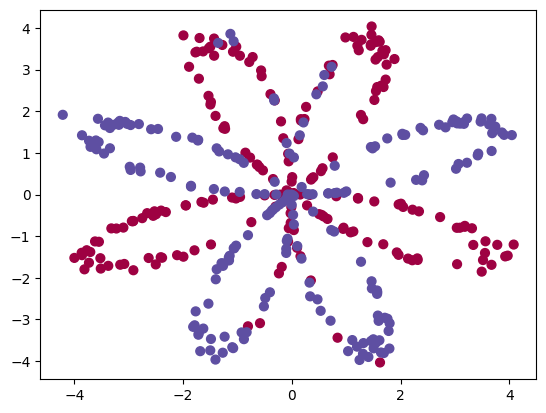

In [73]:
# Visualize the data
plt.scatter(X[0, :], X[1, :], c=y, s=40, cmap=plt.cm.Spectral);

The dataset is a 2-class classification dataset. The data looks like a "flower" with some red (*y=0*) and some blue (*y=1*) points. The goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

In [74]:
shape_X = X.shape
shape_y = y.shape

m = (X.size)//shape_X[0] 

print (f'The shape of X is: {shape_X}')
print (f'The shape of y is: {shape_y}')
print (f'The dataset has {m} training examples!')

The shape of X is: (2, 400)
The shape of y is: (1, 400)
The dataset has 400 training examples!


## Simple Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegressionCV

logist_clf = LogisticRegressionCV()
logist_clf.fit(X.T, y.T)

LogisticRegressionCV()

Accuracy of logistic regression: 47.0% (percentage of correctly labelled datapoints)


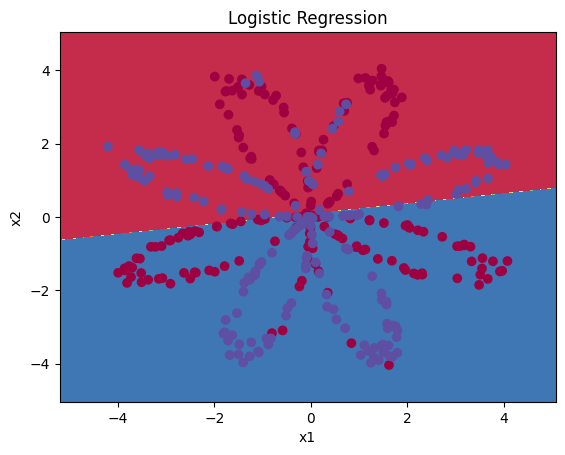

In [76]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: logist_clf.predict(x), X, y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = logist_clf.predict(X.T)
print(f'Accuracy of logistic regression: {float((np.dot(y,LR_predictions) + np.dot(1-y,1-LR_predictions))/float(y.size)*100)}% (percentage of correctly labelled datapoints)')


> The dataset is not linearly separable, so logistic regression doesn't perform well.

## Neural Network

We are going to train a Neural Network with a single hidden layer.

<img src="./images/classification_kiank.png" alt="nn architecture" width="50%" height="auto">

**Mathematically:**  
<br>    
For one example $x^{(i)}$:  
$$
z^{[1](i)} = W^{[1](i)}x^{(i)}  + b^{[1]}\\
a^{[1](i)} = tanh(z^{[1](i)})\\
z^{[2](i)} = W^{[2](i)}a^{[1](i)}  + b^{[2]}\\
\widehat{y}^{(i)} = a^{[2](i)} = \sigma(z^{[2](i)})\\
y^{(i)}_{prediction} = \begin{cases}
                            1   & \quad \text{if } a^{[2](i)} > 0.5\\
                            0   & \quad otherwise
                        \end{cases}
$$
Given the predictions on all the examples, we can also compute the cost $J$ as follows:
$$
J = -\frac{1}{m} \sum_{i=0}^m y^{(i)}log(a^{[2](i)}) + (1 - y^{(i)})log(1 - a^{[2](i)})\\
$$

The general methodology to build a Neural Network is to: 
1. Define the neural network structure ( # of input units, # of hidden units, etc). 
2. Initialize the model's parameters 
3. Loop: 
    - Implement forward propagation 
    - Compute loss 
    - Implement backward propagation to get the gradients 
    - Update parameters (gradient descent)

### Defining the neural network structure

In [77]:
def layer_size(X: np.ndarray, y: np.ndarray) -> tuple:
    """
    Parameters
    ----------
    X:  np.ndarray(shape=(input_size, # examples))
            Input dataset
    y:  np.ndarray(shape=(output_size, # examples))
            Output labels

    Returns
    -------
    tuple
        n_X -- size of input layer\\
        n_y -- size of output layer\\ 
    """

    n_X = X.shape[0]
    n_y = y.shape[0]

    return n_X, n_y

In [78]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_y) = layer_size(X_assess, Y_assess)
print(f"The size of the input layer: n_x = {n_x}")
print(f"The size of the output layer: n_y = {n_y}")

The size of the input layer: n_x = 5
The size of the output layer: n_y = 2


### Initialize model parameters


- Make sure parameters' sizes are right. Refer to the neural network figure above if needed.
- Initialize the weights matrices with random values.
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape *(a,b)*.
- You will initialize the bias vectors as zeros.
    - Use: `np.zeros((a,b))` to initialize a matrix of shape *(a,b)* with zeros.


In [79]:
def initialize_parameters(n_X: int, n_y: int, n_h: int) -> dict:
    """
    Initalize model parameters

    Parameters
    ----------
    n_X: int
           size of input layer
    n_y: int
           size of output layer
    n_h: int
           size of hidden layer

    Returns
    -------
    dict
        W1 -- weight matrix of shape (n_h, n_x)\\
        b1 -- bias vector of shape (n_h, 1)\\
        W2 -- weight matrix of shape (n_y, n_h)\\
        b2 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(10)

    W1 = np.random.randn(n_h, n_X) * 0.1
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.1
    b2 = np.zeros((n_y, 1))

    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

In [80]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)

for item, value in parameters.items():
    print(f"{item}: {value}")
    print(f"Shape of {item}: {value.shape}\n")

W1: [[0.13315865 0.0715279 ]]
Shape of W1: (1, 2)

b1: [[0.]]
Shape of b1: (1, 1)

W2: [[-0.15454003]
 [-0.00083838]
 [ 0.0621336 ]
 [-0.07200856]]
Shape of W2: (4, 1)

b2: [[0.]
 [0.]
 [0.]
 [0.]]
Shape of b2: (4, 1)



### Forward Propagation

- Look at the mathematical representation of the classifier.
- Implement the `sigmoid()` fnction.
- Use `np.tanh()`.
- The steps to implement are:
    1. Retrieve each parameter from the dictionary `parameters` by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}, A^{[2]}$ (the vector of all the predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in `cache`. The `cache` will be given as an input to the `backpropagation` function.

In [81]:
def sigmoid(x: np.ndarray|int) -> float:
    """
    Computes and returns the sigmoid

    Parameters
    ----------
    x : np.ndarray | int

    Returns
    -------
    float
        sigmoid(x)
    """

    s = 1/(1+np.exp(-x))
    return s

In [82]:
def forward_prop(X: np.ndarray, parameters: dict) -> tuple:
    """
    Forward Propagation

    Parameters
    ----------
    X : np.ndarray
        input data
    parameters : dict
        parameters of neural network

    Returns
    -------
    tuple
        A2 -- sigmoid of the Z2\\
        cache -- dict containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}

    return A2, cache


In [83]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_prop(X_assess, parameters)

for item, value in cache.items():
    print(f"{item}: {value}")
    print(f"Shape of {item}: {value.shape}\n")

Z1: [[ 1.7386459   1.74687437  1.74830797]
 [-0.81350569 -0.73394355 -0.78767559]
 [ 0.29893918  0.32272601  0.34788465]
 [-0.2278403  -0.2632236  -0.22336567]]
Shape of Z1: (4, 3)

A1: [[ 0.9400694   0.94101876  0.94118266]
 [-0.67151964 -0.62547205 -0.65709025]
 [ 0.29034152  0.31196971  0.33449821]
 [-0.22397799 -0.25730819 -0.2197236 ]]
Shape of A1: (4, 3)

Z2: [[-1.30737426 -1.30844761 -1.30717618]]
Shape of Z2: (1, 3)

A2: [[0.21292656 0.21274673 0.21295976]]
Shape of A2: (1, 3)



### Cost

For every example, the cost can be calculated by:
$$
J = -\frac{1}{m} \sum_{i=0}^m y^{(i)}log(a^{[2](i)}) + (1 - y^{(i)})log(1 - a^{[2](i)})\\
$$

The cross-entropy loss will be calculated by:
$$
- \sum_{i=0}^{m}y^{(i)}log(a^{[2](i)})
$$

(we can use either `np.multiply()` and then `np.sum()` or directly `np.dot()`).  
Note that if we use `np.multiply()` followed by `np.sum()` the end result will be a type `float`, whereas if we use `np.dot()`, the result will be a `2D numpy array`. We can use `np.squeeze()` to remove redundant dimensions (in the case of single float, this will be reduced to a zero-dimension array). We then cast the array as a type `float`.

In [84]:
def compute_cost(A2: np.ndarray, y: np.ndarray) -> float:
    """
    Compute Cross-entropy Loss

    Parameters
    ----------
    A2 : np.ndarray
        input data
    y : np.ndarray
        output label

    Returns
    -------
    float
        cost
    """
    # ## Using np.multiply() followed by np.sum()
    # logprobs = np.multiply(np.log(A2), y)
    # cost = -np.sum(logprobs)

    ## Using np.dot() and then np.squeeze() and casting to float
    cost = -float(np.squeeze(np.dot(np.log(A2), y.T)))

    return cost

In [85]:
A2, Y_assess, parameters = compute_cost_test_case()

print(f"cost = {compute_cost(A2, Y_assess)}")

cost = 0.6926858869721941


### Backward Propagation

Mathematically,

<img src="./images/grad_summary.png" alt="back prop" width="50%" height="auto">

To compute $\mathrm{d}Z^{[1]}$ we'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the $tanh()$ activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1 - a^{2}$.  
So $g^{[1]'}(Z^{[1]})$ can be computed using `(1- np.power(A1, 2))`.

In [86]:
def back_prop(X: np.ndarray, y: np.ndarray, cache: dict, parameters: dict) -> dict:
    """
    Backward Propagation

    Parameters
    ----------
    X : np.ndarray
        input data
    y : np.ndarray
        output labels
    cache : dict
        dict containing "Z1", "A1", "Z2" and "A2"
    parameters : dict
        dict containing our parameters

    Returns
    -------
    dict
        dict containing "dW1", "db1", "dW2", "db2"
    """
    
    m = X.shape[1]

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]

    dZ2 = A2 - y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

In [87]:
params, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = back_prop(X_assess, Y_assess, cache, params)

for item, value in grads.items():
    print(f"{item}: {value}")
    print(f"Shape of {item}: {value.shape}\n")

dW1: [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
Shape of dW1: (4, 2)

db1: [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
Shape of db1: (4, 1)

dW2: [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
Shape of dW2: (1, 4)

db2: [[-0.16655712]]
Shape of db2: (1, 1)



Use gradient descent. We have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**Mathematically:**
$$
\theta = \theta - \alpha \frac{\partial{J}}{\partial{\theta}}
$$

In [88]:
def update_params(params: dict, grads: dict, learning_rate: float) -> dict:
    """
    Updates parameters using the gradient descent update rule

    Parameters
    ----------
    params : dict
        dict containing parameters
    grads : dict
        dict containing gradients
    learning_rate : float
        Learning Rate

    Returns
    -------
    dict
        dict containing updated parameters
    """

    for param in params.keys():
        params[param] = params[param] - learning_rate*grads[f"d{param}"]
    
    return params

In [89]:
parameters, grads = update_parameters_test_case()
parameters = update_params(parameters, grads, 1.2)

for item, value in parameters.items():
    print(f"{item}: {value}")
    print(f"Shape of {item}: {value.shape}\n")

W1: [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
Shape of W1: (4, 2)

W2: [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
Shape of W2: (1, 4)

b1: [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
Shape of b1: (4, 1)

b2: [[0.00010457]]
Shape of b2: (1, 1)



**Illustration:** The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging).
<br>  

![](./images/sgd.gif) &nbsp;&nbsp; ![](./images/sgd_bad.gif)

### Create Model

In [90]:
def nn_model(X: np.ndarray, y: np.ndarray, n_h: int, learning_rate: float, num_iters: int = 1000, print_cost: bool = False, print_cost_step: int = 100) -> dict:
    """
    Neural Network Model with 1 Hidden Layer

    Parameters
    ----------
    X : np.ndarray
        input data
    y : np.ndarray
        outut label
    n_h : int
        # of neurons in hidden layer
    learning_rate : float
        learning rate
    num_iters : int, default = 1000
        # iteration//
    print_cost : bool, default = False
        True if cost is to printed at every 100 iteratons
    print_cost_step : int, default = 100
        Steps to print cost at if print_cost = True

    Returns
    -------
    dict
        dict containing final parameters
    """

    n_X = layer_size(X, y)[0]
    n_y = layer_size(X, y)[1]

    parameters = initialize_parameters(n_X, n_y, n_h)

    if print_cost:
        print("\nINTERMEDIATE COSTS\n-------------------------")
    for i in range(num_iters):
        A2, cache = forward_prop(X, parameters)

        cost = compute_cost(A2, y)

        grads = back_prop(X, y, cache, parameters)

        parameters = update_params(parameters, grads, learning_rate)

        if print_cost and i%print_cost_step==0:
            print(f"Cost after iteration {i+1}: {cost}")
    
    print(f"\nFINAL COST\n---------------\nFinal Cost: {cost}\n")

    return parameters

In [91]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, 1.02, num_iters=10000, print_cost=True, print_cost_step=1000)

for item, value in parameters.items():
    print(f"{item}: {value}")
    print(f"Shape of {item}: {value.shape}\n")



INTERMEDIATE COSTS
-------------------------
Cost after iteration 1: 1.3787071951480159
Cost after iteration 1001: 0.0003874183858185329
Cost after iteration 2001: 0.00019128688773878167
Cost after iteration 3001: 0.00012692573384262182
Cost after iteration 4001: 9.49594400270563e-05
Cost after iteration 5001: 7.585247135983192e-05
Cost after iteration 6001: 6.314595337818081e-05
Cost after iteration 7001: 5.4085645030734156e-05
Cost after iteration 8001: 4.729917495010008e-05
Cost after iteration 9001: 4.2026052419909715e-05

FINAL COST
---------------
Final Cost: 3.781466949289066e-05

W1: [[-0.43258207  0.9944978 ]
 [-0.76239374  1.28577405]
 [ 0.76955985 -1.40063094]
 [ 0.76214126 -1.38559154]]
Shape of W1: (4, 2)

b1: [[ 0.18659517]
 [ 0.29578242]
 [-0.3364121 ]
 [-0.32821707]]
Shape of b1: (4, 1)

W2: [[-1.56274588 -2.84545224  3.30991559  3.23130664]]
Shape of W2: (1, 4)

b2: [[0.18321829]]
Shape of b2: (1, 1)



### Predictions

In [92]:
def predict(X: np.ndarray, parameters: dict) -> np.array:
    """
    Using the learned parameters, predicts a class for each example in X

    Parameters
    ----------
    X : np.ndarray
        input data
    parameters : dict
        dict containing learned parameters

    Returns
    -------
    np.array
        output label
    """

    A2, _ = forward_prop(X, parameters)
    predictions = (A2 > 0.5)

    return predictions

In [94]:
parameters, X_assess = predict_test_case()

predictions = predict(X_assess, parameters)

print(predictions)

[[ True False  True]]


### Predictions on Planar Dataset


INTERMEDIATE COSTS
-------------------------
Cost after iteration 1: 139.02072075717
Cost after iteration 1001: 56.820476627303705
Cost after iteration 2001: 53.51293428237229
Cost after iteration 3001: 51.75156824366797
Cost after iteration 4001: 50.55762971853719
Cost after iteration 5001: 49.69513303519989
Cost after iteration 6001: 49.095580176794
Cost after iteration 7001: 48.66692558287693
Cost after iteration 8001: 41.55469820950181
Cost after iteration 9001: 40.40382190518597

FINAL COST
---------------
Final Cost: 39.91429717262666



Text(0.5, 1.0, '\nDecision Boundary for hidden layer size 5')

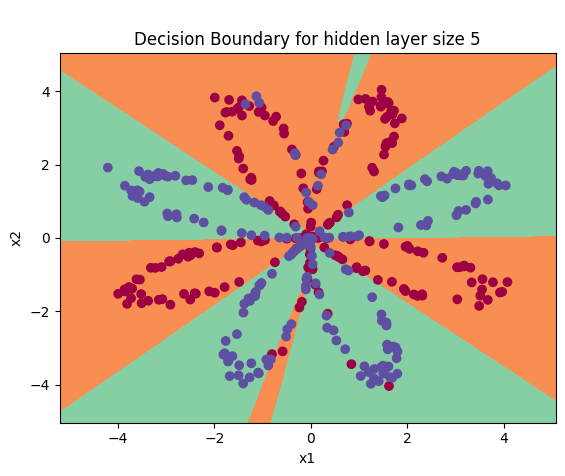

In [117]:
X, y = load_planar_dataset()

# Build a model with a n_h-dimensional hidden layer
n_h = 5
parameters = nn_model(X, y, n_h, 0.9, num_iters=10000, print_cost=True, print_cost_step=1000)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x.T, parameters), X, y)
plt.title(f"\nDecision Boundary for hidden layer size {n_h}")

In [118]:
predictions = predict(X, parameters)

print(f'Accuracy: {float((np.dot(y,predictions.T) + np.dot(1-y,1-predictions.T))/float(y.size)*100)}%')

Accuracy: 89.75%
